The lung cancer data used in this notebook
was published in :
          Hong, Z.Q. and Yang, J.Y. "Optimal Discriminant Plane for a Small
          Number of Samples and Design Method of Classifier on the Plane",
          Pattern Recognition, Vol. 24, No. 4, pp. 317-324, 1991.
        - Donor: Stefan Aeberhard, stefan _at_ coral.cs.jcu.edu.au
        - Date : May, 1992

    32 lines
    57 (1 class attribute, 56 predictive)
    attribute 1 is the class label.
        - All predictive attributes are nominal, taking on integer
          values 0-3
    Missing Attribute Values: Attributes 5 and 39 (*)
    (5 lines have missing data)

    9. Class Distribution:
        - 3 classes,
                1.)     9 observations
                2.)     13     "
                3.)     10     "

     reading the data into:
      y = column data 0, the class
      x = columns 1 through 56

The notebook is to explore fitting models that generalize well to test data. 

Helpful in using CatBoost was this tutorial "CatBoost regression in 6 minutes" by Simon Thiesen: https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

def calcDist(x0, x1):
    return math.sqrt(sum([(x0[i] - x1[i])**2 for i in range(len(x0))]))

def minMaxScaling(a):
    print(f"type={type(a)}\n")
    mina = min(a)
    rangea = max(a) - mina
    out = []
    for i in range(len(a)):
        out.append((a[i] - mina)/rangea)
    return out

def write_projected_to_file(proj, users_idx_to_id: dict, filename: str):
    csv_path2 = os.getcwd() + "/../../test/resources/" + filename
    with open(csv_path2, 'w', encoding="utf-8") as fp:
        #NOTE: i is uIdx in the projected matrix
        for i in range(len(proj)):
            line = f"{users_idx_to_id[i]},{proj[i][0]},{proj[i][1]}\n"
            _ = fp.write(line) # the _ captures the number of characters written.  if missing, that gets written to the CLI
        fp.close()



In [2]:
''' read in the data '''
csv_path = os.getcwd() + "/../../test/resources/ucl_ml_datasets/lung+cancer/lung-cancer_data.txt"

nRows = 32
nCols = 57

# labels are 1, 2, or 3
labels = []
labels_no_missing_data = []
# attributes have values  0-3
utility = []
utility_no_missing_data = []
missingValue = -1

with open(csv_path) as fp:
    i = 0
    for line in fp:
        missing_data = False
        line = line.rstrip()
        if len(line) == 0:
            continue
        items = line.rsplit(",")
        x_i = []
        for j in range(1, len(items)):
            if items[j] == "?":
                x_i.append(missingValue)
                missing_data = True
            else:
                x_i.append(int(items[j]))
        labels.append(int(items[0]) - 1)
        utility.append(x_i)
        if not missing_data:
            labels_no_missing_data.append(int(items[0]) - 1)
            utility_no_missing_data.append(x_i)
        i += 1
    fp.close()

labels_no_missing_data = np.array(labels_no_missing_data)
utility_no_missing_data = np.array(utility_no_missing_data)

print(f'done reading in data\n')

done reading in data



## A look at SVD based projections of the data separated by labels, reduced to 2 dimensions

0 s=[40.74947664  6.29577416  4.81186265  4.09467767  3.67063187  3.2651686
  2.31593807  2.10345909]



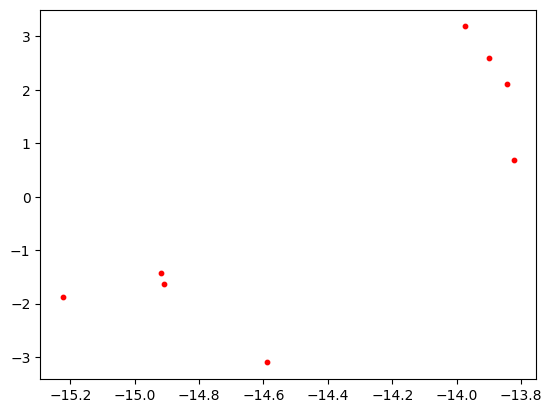

1 s=[43.25241679  5.80928818  5.08158973  4.88012914  4.62482867  4.30469475
  3.6134583   3.16877685  2.81159169  2.21803642]



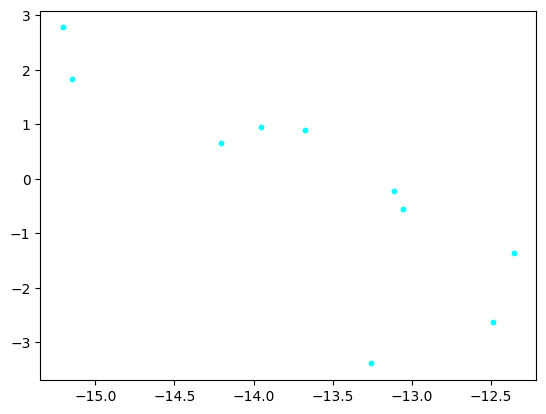

2 s=[41.89323932  6.3161442   5.36725908  4.76978425  4.10060893  3.49642097
  3.40231263  2.80591209  2.23957204]



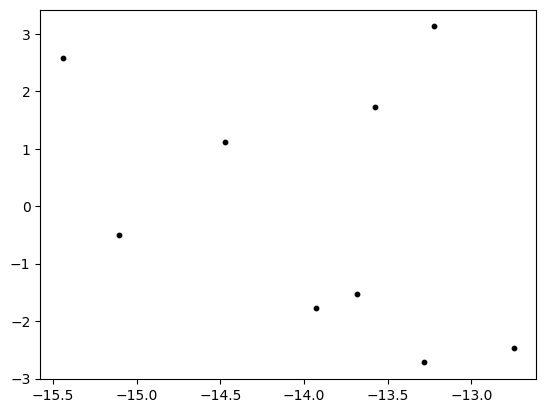

In [3]:
from scipy import linalg

# can see non-linearity in the individual label projections,
# so should consider a  nonlinear dimensionality reduction method.
p=2
clr = {0:'red', 1: 'cyan', 2:'black'}
vps = []
projs = []
for i in range(3):
    indices = labels_no_missing_data == i
    lmnd = labels_no_missing_data[indices]
    umnd = utility_no_missing_data[indices]
    U, s, Vh = linalg.svd(umnd)
    print(f'{i} s={s}\n')
    vp = Vh.T.copy()[:, 0:p]
    projected = np.matmul(umnd, vp)
    plt.scatter(projected[:,0], projected[:,1], s=10, color=clr[i])
    plt.show()
    vps.append(vp)
    projs.append(projected)



## A look at SVD based projection of data, reduced to 2 dimensions

s=[72.13455958  9.46386207  7.72091041  6.75346809  6.47903299  6.01602643
  5.55968427  5.37546843  4.95311595  4.86989157  3.94966496  3.81784701
  3.66035581  3.54406066  3.25177668  3.05968404  2.86141846  2.60421373
  2.52336053  2.24686865  2.09645093  2.02801034  1.63697713  1.45533736
  1.39472266  1.12843462  0.78338147]



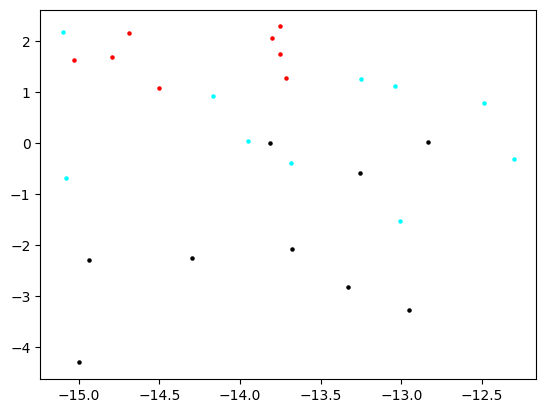

In [4]:
# projection without label separation does not show segmentation in combined plot,
# though the variance in the first singular value is very large compared to the remaining
U, s, Vh = linalg.svd(utility_no_missing_data)
print(f's={s}\n')
'''s=[72.13455958  9.46386207  7.72091041  6.75346809  6.47903299  6.01602643
  5.55968427  5.37546843  4.95311595  4.86989157  3.94966496  3.81784701
  3.66035581  3.54406066  3.25177668  3.05968404  2.86141846  2.60421373
  2.52336053  2.24686865  2.09645093  2.02801034  1.63697713  1.45533736
  1.39472266  1.12843462  0.78338147]'''

vp = Vh.T.copy()[:, 0:p]
projected = np.matmul(utility_no_missing_data, vp)
for i in range(3):
    indices = labels_no_missing_data == i
    x = projected[:,0]
    x = x[indices]
    y = projected[:,1]
    y = y[indices]
    plt.scatter(x, y, s=5, color=clr[i])

plt.show()


To use CatBoost or LightGBM below, we split the data into train and test.
If we had enough data we would split it into train, dev, and test.

For such a small dataset, we use 80% train, 20% test.
We have 3 labels, so we choose 80% from each for train, and the rest for test.


In [5]:
X = utility_no_missing_data
y = labels_no_missing_data
x_train = []
x_test = []
y_train = []
y_test = []
for i in range(3):
    indices = y == i
    x = X[indices]
    tr_indices = np.random.choice(x.shape[0], int(x.shape[0] * 0.8), replace=False)
    te_indices = np.array(list(set([i for i in range(len(x))]) - set(tr_indices)))
    x_train.extend(x[tr_indices].tolist())
    x_test.extend(x[te_indices].tolist())
    for _ in range(x[tr_indices].shape[0]):
        y_train.append(i)
    for _ in range(x[te_indices].shape[0]):
        y_test.append(i)

x_train = np.array(x_train)
x_test = np.array(x_test)
print(f'X.shape={X.shape}, lengths={len(X)}, {len(X[0])}\n')
print(f'x_train.shape={x_train.shape}, lengths={len(x_train)}, {len(x_train[0])}\n')
print(f'x_test.shape={x_test.shape}, lengths={len(x_test)}, {len(x_test[0])}\n')
print(f'len(x_train)={len(x_train)}, len(y_train)={len(y_train)}\n')
print(f'len(x_test)={len(x_test)}, len(y_test)={len(y_test)}\n')
print(f'done splitting into train and test\n')

X.shape=(27, 56), lengths=27, 56

x_train.shape=(21, 56), lengths=21, 56

x_test.shape=(6, 56), lengths=6, 56

len(x_train)=21, len(y_train)=21

len(x_test)=6, len(y_test)=6

done splitting into train and test



## A look at LocallyLinearEmbedding

X_transformed.shape=(27, 2)



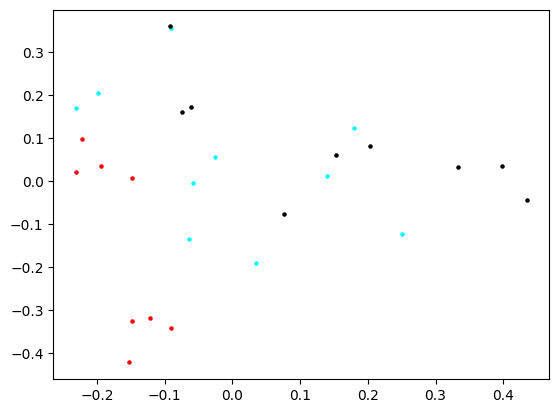

In [6]:
from sklearn.manifold import LocallyLinearEmbedding

p = 2
lle = LocallyLinearEmbedding(n_components=p)
X_transformed = lle.fit_transform(X, y)
print(f'X_transformed.shape={X_transformed.shape}\n')

#lle.get_feature_names_out()
#lle.get_params()

#plt.scatter(X_transformed[:,0], X_transformed[:,1], s=5, color=clr[i])   
#plt.show()

# show the different labels as different colors
for i in range(3):
    indices = y == i
    xp = X_transformed[:,0]
    xp = xp[indices]
    yp = X_transformed[:,1]
    yp = yp[indices]
    plt.scatter(xp, yp, s=5, marker='o', color=clr[i])

plt.show()

## A look at T-SNE

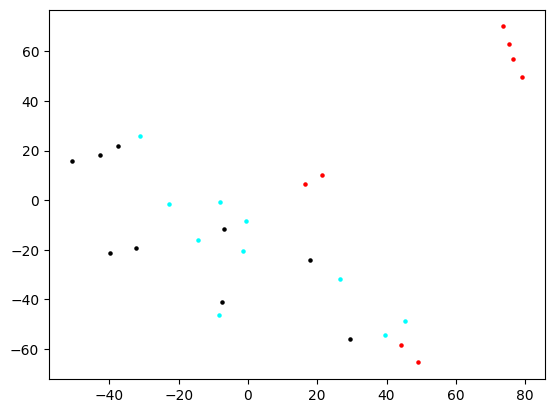

In [7]:
from sklearn.manifold import TSNE

#init='random'
X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', 
                  method='exact', perplexity=2).fit_transform(X)
X_embedded.shape

for i in range(3):
    indices = y == i
    xp = X_embedded[:,0]
    xp = xp[indices]
    yp = X_embedded[:,1]
    yp = yp[indices]
    plt.scatter(xp, yp, s=5, marker='o', color=clr[i])

plt.show()

## A look at CatBoost, which is supervised machine learning and so uses the labels

In [33]:
from catboost import CatBoostClassifier, Pool
import shap

cat_features = [0,1,2] #this is needed when they're categorical, e.g. ['a','b','c']
loss_f = 'MultiClass'
#loss_f = 'logloss' #default
#l2_leaf_reg = 8 #default is 3.  try values from 2 to 30?
#depth=6 #default
model = CatBoostClassifier(learning_rate=0.03, loss_function=loss_f, metric_period=100,
                          classes_count=3)

# helpful: https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329
grid_params = {'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid_params, x_train, y_train, verbose=True, plot=True)
#model.fit(x_train, y_train, verbose=True, plot=True)

print(f'done training CatBoostClassifier\n')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0799028	test: 1.0944398	best: 1.0944398 (0)	total: 9.13ms	remaining: 9.13s
100:	learn: 0.3261408	test: 0.7644940	best: 0.7644940 (100)	total: 49.5ms	remaining: 441ms
200:	learn: 0.1073939	test: 0.6433666	best: 0.6433666 (200)	total: 83.9ms	remaining: 334ms
300:	learn: 0.0461269	test: 0.6458832	best: 0.6433666 (200)	total: 119ms	remaining: 276ms
400:	learn: 0.0251019	test: 0.6880138	best: 0.6433666 (200)	total: 155ms	remaining: 231ms
500:	learn: 0.0162521	test: 0.7155847	best: 0.6433666 (200)	total: 215ms	remaining: 214ms
600:	learn: 0.0115233	test: 0.7454649	best: 0.6433666 (200)	total: 272ms	remaining: 181ms
700:	learn: 0.0087414	test: 0.7755879	best: 0.6433666 (200)	total: 326ms	remaining: 139ms
800:	learn: 0.0070454	test: 0.7923735	best: 0.6433666 (200)	total: 371ms	remaining: 92.2ms
900:	learn: 0.0058164	test: 0.8174286	best: 0.6433666 (200)	total: 419ms	remaining: 46ms
999:	learn: 0.0049575	test: 0.8368954	best: 0.6433666 (200)	total: 481ms	remaining: 0us

bestTest = 0

In [42]:
sorted_feature_importance = model.feature_importances_.argsort()
print(f'sorted_feature_importance={sorted_feature_importance}\n')

sorted_feature_importance=[ 0 49 42 28  8 21 20 17 16 23 35  4 46 29 27 15 53 37 54 38 44 47 50 40
 24 48 25 45 26 18 39 31 43 41 12 10 34  3 30 11  1  6  7 32 14 51 22 36
 55  2  9 13 33  5 52 19]



true=0, predicted=[0],  prob=[0.96935968 0.02001635 0.01062397]
true=0, predicted=[0],  prob=[0.94826822 0.04203113 0.00970065]
true=1, predicted=[0],  prob=[0.78874919 0.03734649 0.17390432]
true=1, predicted=[2],  prob=[0.05551519 0.08408683 0.86039798]
true=2, predicted=[2],  prob=[0.05491153 0.0200082  0.92508027]
true=2, predicted=[2],  prob=[0.00295062 0.01367324 0.98337614]
RMSE: 0.58
R2: 0.50
substantial, moderate and weak R^2 scores respectively are 0.75, 0.50, and 0.25



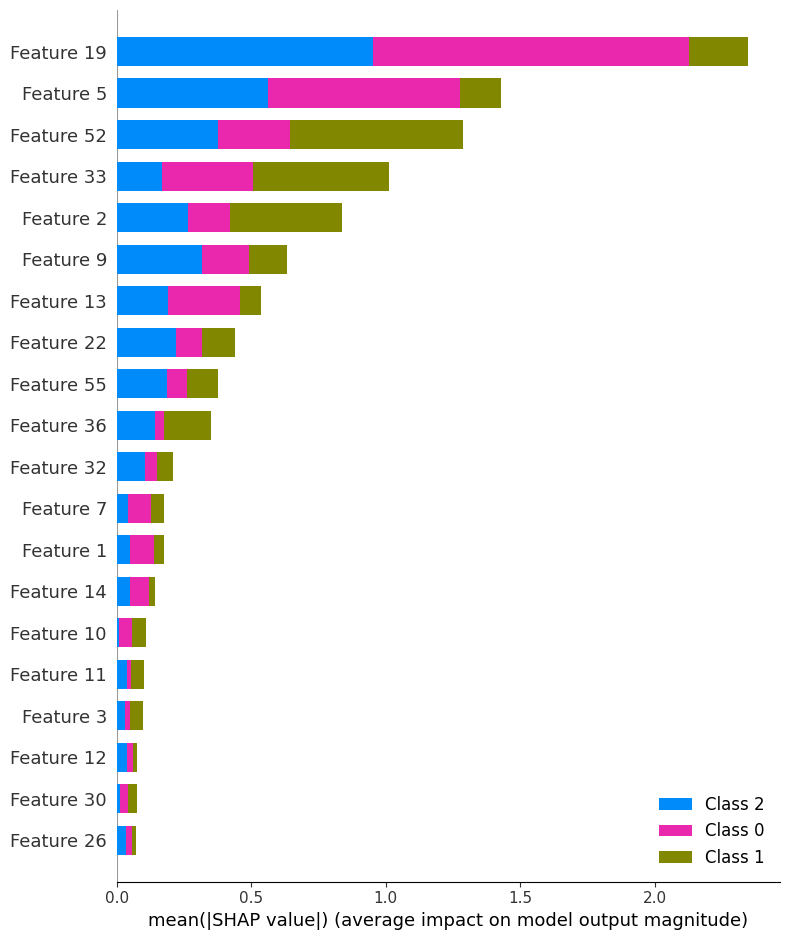


With such a small dataset, we likely overfit the training dataset.  The class '1' labels are not predicted correctly.

done testing with CatBoostClassifier



In [44]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_pred_test = model.predict(x_test)
y_proba_test = model.predict_proba(x_test)
assert(len(y_pred_test) == len(y_test))
for i in range(len(y_test)):
    print(f'true={y_test[i]}, predicted={y_pred_test[i]},  prob={y_proba_test[i]}')

rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
r2 = r2_score(y_test, y_pred_test)
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))
# this from Google generative AI:
print(f'substantial, moderate and weak R^2 scores respectively are 0.75, 0.50, and 0.25\n')

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)

print(f"\nWith such a small dataset, we likely overfit the training dataset.  The class '1' labels are not predicted correctly.\n")
print(f'done testing with CatBoostClassifier\n')


In [32]:
from catboost import CatBoost, CatBoostRegressor

# used to compare models, but can be run for a single model:
'''
param = {'iterations':500, 'learning_rate':0.03, 'loss_function':loss_f, 'metric_period':100,
                          'classes_count':3}
model = CatBoost(param)
model.fit(x_train, y_train, verbose=True, plot=True)

print(f'done training CatBoost\n')

preds_class = model.predict(x_test, prediction_type='Class')
preds_proba = model.predict(x_test, prediction_type='Probability')
preds_raw_vals = model.predict(x_test, prediction_type='RawFormulaVal')
print("Class", preds_class)
print("Proba", preds_proba)
print("Raw", preds_raw_vals)

print(f'done testing with CatBoost\n')
'''
'''
loss function choices:
 |      'RMSE' <-- default
 |      'MAE'  <-- Mean Absolute  Error
 |      'Quantile:alpha=value'
 |      'LogLinQuantile:alpha=value'
 |      'Poisson'
 |      'MAPE'   <-- Mean Absolute Percentage Error
 |      'Lq:q=value'
 |      'SurvivalAft:dist=value;scale=value'
 '''

## still editing here

loss_f = 'RMSE'
#l2_leaf_reg = 8 #default is 3.  try values from 2 to 30?
#depth=6 #default
model = CatBoostRegressor(learning_rate=0.03, loss_function=loss_f, metric_period=100, verbose=True)
#l2_leaf_reg
model.fit(x_train, y_train, plot=True)

prediction_type='RawFormulaVal' #default
prediction_type='Class'
prediction_type='Probability'
y_pred_test = model.predict(x_test, prediction_type='Class')
y_proba_test = model.predict(x_test, prediction_type='RawFormulaVal')
assert(len(y_pred_test) == len(y_test))
for i in range(len(y_test)):
    print(f'true={y_test[i]}, predicted={y_pred_test[i]},  prob={y_proba_test[i]}')

print(f'done training CatBoostRegressor\n')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7803077	total: 20.7ms	remaining: 20.7s
100:	learn: 0.2875250	total: 142ms	remaining: 1.26s
200:	learn: 0.0923248	total: 285ms	remaining: 1.13s
300:	learn: 0.0394324	total: 415ms	remaining: 963ms
400:	learn: 0.0185740	total: 550ms	remaining: 822ms
500:	learn: 0.0087490	total: 672ms	remaining: 669ms
600:	learn: 0.0041211	total: 802ms	remaining: 533ms
700:	learn: 0.0019412	total: 920ms	remaining: 392ms
800:	learn: 0.0009143	total: 1.11s	remaining: 276ms
900:	learn: 0.0004307	total: 1.23s	remaining: 135ms
999:	learn: 0.0002044	total: 1.46s	remaining: 0us


IndexError: index 0 is out of bounds for axis 0 with size 0

paused here... lightgbm next